## Import data from AWS S3

In [1]:
import sys
sys.path.insert(0, '/home/khiem/Dropbox/Education/Drexel/DSCI-591/Project/Walmart-Strategic-Sales-Forecasting')

In [2]:
import boto3
import pandas as pd

bucket = 'dsci-632'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket="dsci-632", Key="CA_3_sales_data.csv")
df = pd.read_csv(obj['Body'], index_col=0, parse_dates=True) # 'Body' is a keyword
print(df.head())

            wm_yr_wk  wday  month  year event_name_1 event_type_1  \
2011-01-29     11101     1      1  2011         None         None   
2011-01-30     11101     2      1  2011         None         None   
2011-01-31     11101     3      1  2011         None         None   
2011-02-01     11101     4      2  2011         None         None   
2011-02-02     11101     5      2  2011         None         None   

           event_name_2 event_type_2      cpi  unemployment_rate  gas_price  \
2011-01-29         None         None  221.187                9.1      3.163   
2011-01-30         None         None  221.187                9.1      3.163   
2011-01-31         None         None  221.187                9.1      3.155   
2011-02-01         None         None  221.898                9.0      3.155   
2011-02-02         None         None  221.898                9.0      3.155   

            snap_ca  ca_walmart  ca_hobbies  ca_household  ca_foods  \
2011-01-29        0       39.50       2

## Data Processing

In [3]:
def get_day_value(df):
    """ Preprocessing function
    Creates day column.
    """
    df = df.assign(**{'day': df.index.day})
    
    return df
df_processed = df.pipe(get_day_value)

event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
df_processed = df_processed.join([pd.get_dummies(df[col], prefix=col) for col in event_cols]).drop(event_cols, axis=1).rename(str.lower, axis=1)
pd.set_option('display.max_columns', None)
print(df_processed.head(1))

            wm_yr_wk  wday  month  year      cpi  unemployment_rate  \
2011-01-29     11101     1      1  2011  221.187                9.1   

            gas_price  snap_ca  ca_walmart  ca_hobbies  ca_household  \
2011-01-29      3.163        0        39.5       20.14          36.5   

            ca_foods  store_sales  median_price  min_price  max_price  day  \
2011-01-29      63.0       4739.0           3.0        0.2       22.0   29   

            event_name_1_chanukah end  event_name_1_christmas  \
2011-01-29                          0                       0   

            event_name_1_cinco de mayo  event_name_1_columbusday  \
2011-01-29                           0                         0   

            event_name_1_easter  event_name_1_eid al-fitr  \
2011-01-29                    0                         0   

            event_name_1_eidaladha  event_name_1_father's day  \
2011-01-29                       0                          0   

            event_name_1_hallowee

## Data Analysis

In [4]:
timeseries_cols = ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods']
time_cols = ['wm_yr_wk', 'wday', 'day', 'month', 'year']
target_col = ['store_sales', 'median_price', 'min_price', 'max_price']
cat_cols = [col for col in df_processed.columns if col not in timeseries_cols + time_cols + target_col]

print(cat_cols)

['snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 'event_name_1_superbowl', 'event_name_1_thanksgiving', 'event_name_1_valentinesday', 'event_name_1_veteransday', 'event_type_1_cultural', 'event_type_1_national', 'event_type_1_none', 'event_type_1_religious', 'event_type_1_spo

In [5]:
df_used = df_processed[timeseries_cols+target_col+cat_cols+time_cols]
df_used = df_used.rolling(7).mean().dropna()

In [6]:
# from statsmodels.tsa.stattools import grangercausalitytests
# import numpy as np

# maxlag=12
# test = 'ssr_chi2test'
# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.

#     data      : pandas dataframe containing the time series variables
#     variables : list containing names of the time series variables.
#     """
#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df
# grangers_causation_matrix(df_used, variables = df_used.columns)  

In [7]:
from statsmodels.tsa.stattools import adfuller

nobs = 30
df_original = df_used
df_test = df_used[-nobs:]
df_train = df_used[0:-nobs]

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value > sig:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)

 cpi : P-Value = 0.405 => Non-stationary.
 unemployment_rate : P-Value = 0.874 => Non-stationary.
 gas_price : P-Value = 0.47 => Non-stationary.
 store_sales : P-Value = 0.216 => Non-stationary.
 median_price : P-Value = 0.054 => Non-stationary.
 max_price : P-Value = 0.234 => Non-stationary.
 wm_yr_wk : P-Value = 0.975 => Non-stationary.


/home/khiem/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


 year : P-Value = 0.936 => Non-stationary.


In [8]:
df_train = df_train.diff().dropna()
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [9]:
df_train.head(10)

,cpi,unemployment_rate,gas_price,ca_walmart,ca_hobbies,ca_household,ca_foods,store_sales,median_price,min_price,max_price,snap_ca,event_name_1_chanukah end,event_name_1_christmas,event_name_1_cinco de mayo,event_name_1_columbusday,event_name_1_easter,event_name_1_eid al-fitr,event_name_1_eidaladha,event_name_1_father's day,event_name_1_halloween,event_name_1_independenceday,event_name_1_laborday,event_name_1_lentstart,event_name_1_lentweek2,event_name_1_martinlutherkingday,event_name_1_memorialday,event_name_1_mother's day,event_name_1_nbafinalsend,event_name_1_nbafinalsstart,event_name_1_newyear,event_name_1_none,event_name_1_orthodoxchristmas,event_name_1_orthodoxeaster,event_name_1_pesach end,event_name_1_presidentsday,event_name_1_purim end,event_name_1_ramadan starts,event_name_1_stpatricksday,event_name_1_superbowl,event_name_1_thanksgiving,event_name_1_valentinesday,event_name_1_veteransday,event_type_1_cultural,event_type_1_national,event_type_1_none,event_type_1_religious,event_type_1_sporting,event_name_2_cinco de mayo,event_name_2_easter,event_name_2_father's day,event_name_2_none,event_name_2_orthodoxeaster,event_type_2_cultural,event_type_2_none,event_type_2_religious,wm_yr_wk,wday,day,month,year
2011-02-05,1.015714e-01,-0.014286,-0.001143,1.550000,0.157143,-0.342857,-1.080000,102.428571,0.022857,0.000000e+00,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,-3.428571,0.142857,0.0
2011-02-06,1.015714e-01,-0.014286,-0.001143,0.742857,-1.151429,3.714286,-1.780000,107.714286,0.022857,0.000000e+00,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.000000,0.0,-0.142857,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,-3.428571,0.142857,0.0
2011-02-07,1.015714e-01,-0.014286,0.004286,0.464286,-0.837143,-1.121429,-0.874286,161.000000,0.022857,-2.775558e-17,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,-3.428571,0.142857,0.0
2011-02-08,2.842171e-14,0.000000,0.004286,-0.454286,1.080000,0.235714,0.094286,30.714286,0.022857,2.775558e-17,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,1.000000,0.000000,0.0
2011-02-09,0.000000e+00,0.000000,0.004286,0.378571,-0.617143,1.021429,1.225714,103.857143,0.022857,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,1.000000,0.000000,0.0
2011-02-10,-2.842171e-14,0.000000,0.004286,-0.075714,-0.514286,-0.157143,0.565714,5.285714,0.022857,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,1.000000,0.000000,0.0
2011-02-11,2.842171e-14,0.000000,0.004286,-0.151429,-0.257143,-0.550000,0.660000,-46.142857,0.022857,-2.775558e-17,0.0,-0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,1.000000,0.000000,0.0
2011-02-12,0.000000e+00,0.000000,0.004286,0.378571,0.874286,-0.157143,0.094286,-38.428571,0.002857,2.775558e-17,0.0,-0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [10]:
from statsmodels.tsa.api import VAR

df_train = df_train.dropna()
model = VAR(df_train)
# x = model.select_order(maxlags=12)
# x.summary()

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [12]:
model_fitted = model.fit(30)
# model_fitted.summary()

In [13]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_used.values[-lag_order:]
forecast_input

30


array([[ 238.992     ,    5.1       ,    2.23042857, ...,   20.        ,
           4.        , 2016.        ],
       [ 238.992     ,    5.1       ,    2.24      , ...,   21.        ,
           4.        , 2016.        ],
       [ 238.992     ,    5.1       ,    2.24357143, ...,   22.        ,
           4.        , 2016.        ],
       ...,
       [ 239.557     ,    4.8       ,    2.33928571, ...,   17.        ,
           5.        , 2016.        ],
       [ 239.557     ,    4.8       ,    2.34214286, ...,   18.        ,
           5.        , 2016.        ],
       [ 239.557     ,    4.8       ,    2.345     , ...,   19.        ,
           5.        , 2016.        ]])

In [14]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_original.index[-nobs:], columns=df_used.columns + '_1d')
df_forecast["store_sales_1d"]

2016-04-23   -2.854344e+08
2016-04-24   -3.354596e+08
2016-04-25   -3.189629e+08
2016-04-26   -2.724973e+08
2016-04-27   -1.209851e+08
2016-04-28   -1.148006e+08
2016-04-29   -1.873623e+08
2016-04-30   -5.954311e+06
2016-05-01    2.573618e+07
2016-05-02    2.532528e+07
2016-05-03    9.721788e+07
2016-05-04   -6.210277e+07
2016-05-05   -8.851022e+06
2016-05-06    2.452360e+07
2016-05-07    2.365700e+07
2016-05-08   -2.699698e+07
2016-05-09    3.259250e+07
2016-05-10   -4.148161e+07
2016-05-11    6.104962e+07
2016-05-12    4.061373e+07
2016-05-13    1.231298e+08
2016-05-14    1.444829e+08
2016-05-15    1.401351e+08
2016-05-16    1.363837e+08
2016-05-17    5.227106e+07
2016-05-18    2.542922e+07
2016-05-19    5.218243e+07
2016-05-20    3.869543e+07
2016-05-21   -2.839750e+07
2016-05-22   -5.763224e+07
Name: store_sales_1d, dtype: float64

In [15]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_original[0:-nobs], df_forecast)        
df_results.head(10)

,cpi_1d,unemployment_rate_1d,gas_price_1d,ca_walmart_1d,ca_hobbies_1d,ca_household_1d,ca_foods_1d,store_sales_1d,median_price_1d,min_price_1d,max_price_1d,snap_ca_1d,event_name_1_chanukah end_1d,event_name_1_christmas_1d,event_name_1_cinco de mayo_1d,event_name_1_columbusday_1d,event_name_1_easter_1d,event_name_1_eid al-fitr_1d,event_name_1_eidaladha_1d,event_name_1_father's day_1d,event_name_1_halloween_1d,event_name_1_independenceday_1d,event_name_1_laborday_1d,event_name_1_lentstart_1d,event_name_1_lentweek2_1d,event_name_1_martinlutherkingday_1d,event_name_1_memorialday_1d,event_name_1_mother's day_1d,event_name_1_nbafinalsend_1d,event_name_1_nbafinalsstart_1d,event_name_1_newyear_1d,event_name_1_none_1d,event_name_1_orthodoxchristmas_1d,event_name_1_orthodoxeaster_1d,event_name_1_pesach end_1d,event_name_1_presidentsday_1d,event_name_1_purim end_1d,event_name_1_ramadan starts_1d,event_name_1_stpatricksday_1d,event_name_1_superbowl_1d,event_name_1_thanksgiving_1d,event_name_1_valentinesday_1d,event_name_1_veteransday_1d,event_type_1_cultural_1d,event_type_1_national_1d,event_type_1_none_1d,event_type_1_religious_1d,event_type_1_sporting_1d,event_name_2_cinco de mayo_1d,event_name_2_easter_1d,event_name_2_father's day_1d,event_name_2_none_1d,event_name_2_orthodoxeaster_1d,event_type_2_cultural_1d,event_type_2_none_1d,event_type_2_religious_1d,wm_yr_wk_1d,wday_1d,day_1d,month_1d,year_1d,cpi_forecast,unemployment_rate_forecast,gas_price_forecast,ca_walmart_forecast,ca_hobbies_forecast,ca_household_forecast,ca_foods_forecast,store_sales_forecast,median_price_forecast,min_price_forecast,max_price_forecast,snap_ca_forecast,event_name_1_chanukah end_forecast,event_name_1_christmas_forecast,event_name_1_cinco de mayo_forecast,event_name_1_columbusday_forecast,event_name_1_easter_forecast,event_name_1_eid al-fitr_forecast,event_name_1_eidaladha_forecast,event_name_1_father's day_forecast,event_name_1_halloween_forecast,event_name_1_independenceday_forecast,event_name_1_laborday_forecast,event_name_1_lentstart_forecast,event_name_1_lentweek2_forecast,event_name_1_martinlutherkingday_forecast,event_name_1_memorialday_forecast,event_name_1_mother's day_forecast,event_name_1_nbafinalsend_forecast,event_name_1_nbafinalsstart_forecast,event_name_1_newyear_forecast,event_name_1_none_forecast,event_name_1_orthodoxchristmas_forecast,event_name_1_orthodoxeaster_forecast,event_name_1_pesach end_forecast,event_name_1_presidentsday_forecast,event_name_1_purim end_forecast,event_name_1_ramadan starts_forecast,event_name_1_stpatricksday_forecast,event_name_1_superbowl_forecast,event_name_1_thanksgiving_forecast,event_name_1_valentinesday_forecast,event_name_1_veteransday_forecast,event_type_1_cultural_forecast,event_type_1_national_forecast,event_type_1_none_forecast,event_type_1_religious_forecast,event_type_1_sporting_forecast,event_name_2_cinco de mayo_forecast,event_name_2_easter_forecast,event_name_2_father's day_forecast,event_name_2_none_forecast,event_name_2_orthodoxeaster_forecast,event_type_2_cultural_forecast,event_type_2_none_forecast,event_type_2_religious_forecast,wm_yr_wk_forecast,wday_forecast,day_forecast,month_forecast,year_forecast
2016-04-23,-63934.633250,-781.484687,5316.882411,2.835107e+04,-2.532890e+05,4.509962e+06,-1.508750e+06,-2.854344e+08,77.914006,-15.602097,-2466.434444,-155175.169096,-3541.089857,28134.519802,19637.019138,4489.503522,51233.745425,-0.029870,-7031.455499,-15269.525661,61670.023061,6185.549757,-96793.119036,-27818.281670,-0.025268,-4283.869102,-642.726269,-0.332760,-708.380004,11932.405750,-0.024955,114522.307092,0.001763,-6134.728419,-1234.638679,-9079.328098,-25340.669231,-4557.326913,-11432.549801,-34892.506471,-18653.044459,-30391.391365,-0.031923,75446.988037,-90642.570761,114522.307092,-75658.243642,-23668.480725,3787.788835,-8515.813616,1605.847785,5002.201387,-1880.024390,-3122.176997,5002.201387,-1880.024390,1.240874e+06,0.0,4.610971e+06,-155169.805625,2015.971700,-6.369564e+04,-776.384687,5319

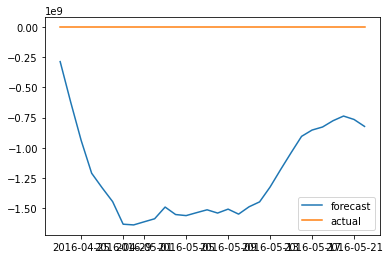

In [16]:
import matplotlib.pyplot as plt

plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()


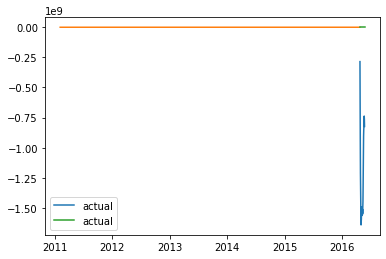

In [17]:
plt.plot(df_results["store_sales_forecast"].index, df_results["store_sales_forecast"], label = "actual")
plt.plot(df_original["store_sales"][0:-nobs].index, df_original["store_sales"][0:-nobs])
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()